In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import pandas as pd
import math


import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import pandas as pd
import re

import pandas as pd
import gspread
from oauth2client.service_account import ServiceAccountCredentials
from google.colab import auth
from google.auth import default

from scipy.optimize import curve_fit
import itertools


In [2]:
# Parameters
T = 24 #Duration of each day
delta = 0.2
S0 = 2
B0=1e8

## Define default parameters based on the table values
#cy = 1.01053e9
#cx = 1.1053e9
#Vmx = 8.7129e-10
#Kmx=1
betax = 2e-10
#Kmy=1
#Vmy = 8.27129e-10
#betay = 1e-10

Kix=1e11
#Kiy=1e11


strain_colors = ["#177E89", "#FFC857",  "#FF6B6B",  "#90BE6D", "#00A6A6", "#FF9F1C", "#7A9E7E"]


strain_lbls=['trpC', 'metA', 'ilvA', 'thrC', 'tyrA'] #, 'pheA', 'tyrA'
X_values = [0, 1, 2, 3, 4, 8]
X_values = [8]

sheet_url = 'https://docs.google.com/spreadsheets/d/1gop5K6NQsGI5mKA-cxuEx-CuQbaWnsoeCYPiI1mlH7k/edit?usp=sharing'



## Population dynamics model

In [3]:
def model_population_(t, u, parameters):
    num_strains = len(parameters)

    # Initialize the change in concentrations for each component
    dSdt = 0
    dAdt = [0] * num_strains  # Change in concentrations of amino acids
    dBdt = [0] * num_strains  # Change in bacterial densities

    # Loop through each strain's parameters
    for i in range(num_strains):
        # Extract parameters for the current strain
        Vm, Km, c, beta, Ki = parameters[i]
        Bi = max(0, u[1 + num_strains + i])
        A = max(0, u[i + 1])
        S = max(0, u[0])


        # Calculate uptake rate for the current strain
        U = Vm * S / (Km + S) * (A / (1 + A))


        # Calculate growth rate for the current strain
        G = c * U

        # Update the change in concentrations for each component
        dSdt -= U * S * Bi

        for j in range(num_strains):
          Bj=u[1 + num_strains + i]
          if i == j:
            dAdt[i] -= U * A * Bi  # Consumption of amino acid by auxotroph strain
          else:
            Aj=u[j + 1]
            Vmj, Kmj, cj, betaj, Kij = parameters[j]
            Uj = Vmj * S / (Kmj + S) * (Aj / (1 + Aj))
            Gj = cj * Uj

            dAdt[i] += betaj * Gj * Bj  # Production of amino acid by all other strains

        dBdt[i] = G * Bi  # Growth rate multiplied by bacterial density


    return [dSdt] + dAdt + dBdt

def simulate_multistrain_(T, u0, p):

    # Define the time span
    t_span = (0, T)

    # Solve the ODE
    sol = solve_ivp(lambda t, y: model_population(t, y, p), t_span, u0, t_eval=np.linspace(0, T, 100))

    # Create a DataFrame to store the results
    df = pd.DataFrame(sol.y.transpose(), columns=['S'] + [f'A_{i+1}' for i in range(len(p))] + [f'X_{i+1}' for i in range(len(p))])

    # Add time column to DataFrame
    df['Time'] = sol.t

    return df


In [4]:
def plot_simulation_(strains_parameters, results_df, T, environmental_conditions):
    """
    Plot the simulation results including environmental input, bacterial density,
    relative abundance, and Shannon diversity over time.
    """
    num_strains = len(strains_parameters)

    # --- Create subplots (now 4 rows)
    fig, axs = plt.subplots(4, figsize=(6, 12), sharex=True)

    # --- Plot 1: Environment Input ---
    lbls = []
    for i in range(num_strains):
        strain_name=strains_parameters[i]['name'][-4:]
        istrain = strain_lbls.index(strain_name[-4:])
        baseline_color = strain_colors[istrain]
        cmap_aa = generate_custom_colormap((1,1,1), baseline_color)
        #concentrations = results_df[f'A_{i+1}'].values

        time = results_df['Time'].values/T
        #for j, concentration in enumerate(environmental_conditions[i]):
        for j in range(len(environmental_conditions)):
            concentration=environmental_conditions[j][i]/Amax

            color = cmap_aa(concentration)
            axs[0].fill_between(time[j:j+2], i, i+1, color=color, alpha=0.7)
        lbls.append(strains_parameters[i]['name'][-4:])
    axs[0].set_yticks(np.arange(num_strains) + 0.5)
    axs[0].set_yticklabels(lbls)

    axs[0].spines['top'].set_visible(False)
    axs[0].spines['right'].set_visible(False)
    axs[0].spines['bottom'].set_visible(False)
    axs[0].spines['left'].set_visible(False)
    axs[0].set_ylim([0, 10])
    axs[0].text(results_df['Time'].iloc[-1]/T / 2, num_strains + 0.5, 'Environment', ha='center', fontsize=14)

    # --- Plot 2: Bacterial Density (log-scale) ---
    for i in range(num_strains):
        strain_name = strains_parameters[i]['name'][-4:]
        istrain = strain_lbls.index(strain_name)
        color = strain_colors[istrain]
        axs[1].plot(results_df['Time'] / T, results_df[f'X_{i+1}'], color=color, linewidth=3)
    axs[1].set_yscale('log')
    axs[1].set_ylim([1e6, 5e9])
    axs[1].set_ylabel("Density (cells/mL)", fontsize=16)

    # --- Plot 3: Relative Abundance ---
    total_density = results_df[[f'X_{i+1}' for i in range(num_strains)]].sum(axis=1)
    for i in range(num_strains):
        strain_name = strains_parameters[i]['name'][-4:]
        istrain = strain_lbls.index(strain_name)
        color = strain_colors[istrain]
        axs[2].plot(results_df['Time'] / T, 100 * results_df[f'X_{i+1}'] / total_density, color=color, linewidth=3, label=strain_name)
    axs[2].set_ylabel("Relative abundance (%)", fontsize=16)

    # --- Plot 4: Diversity Index ---
    relative_proportions = calculate_relative_proportion(results_df)
    diversities = [shannon_diversity(row.values) for _, row in relative_proportions.iterrows()]
    axs[3].plot(results_df['Time'].values / T, diversities, color='k', lw=3)
    axs[3].set_ylabel("Diversity Index", fontsize=16)
    axs[3].set_ylim(0, 1.8)

    # --- Shared x-axis ---
    axs[3].set_xlabel("Time (seasons)", fontsize=16)
    axs[3].set_xlim([0, (results_df['Time']/T).iloc[-1]])

    # --- Styling ---
    for ax in axs:
        ax.tick_params(axis='both', labelsize=14)
    axs[1].legend(lbls, fontsize=12, loc="upper right")
    axs[2].legend(lbls, fontsize=12, loc="upper right")

    plt.tight_layout()
    plt.show()


In [5]:
def calculate_relative_proportion(results_df):
    # Extract columns for bacterial densities
    bacterial_density_columns = [col for col in results_df.columns if col.startswith('X_')]

    # Calculate total population
    total_population = results_df[bacterial_density_columns].sum(axis=1)

    # Calculate relative proportion of each bacterial strain to the total population
    relative_proportions = results_df[bacterial_density_columns].div(total_population, axis=0) * 100

    return relative_proportions

def shannon_diversity(freqs):
    total_freq = np.sum(freqs)
    if total_freq == 0:
        return 0  # Handle the case when there are no strains
    proportions = freqs / total_freq
    non_zero_proportions = proportions[proportions != 0]
    diversity = -np.sum(non_zero_proportions * np.log(non_zero_proportions))
    return diversity


In [29]:

with open('%sstrains_parameters.pkl'%SAVE_DIR, 'rb') as f:
    strains_parameters = pickle.load(f)




---
## Genetic algorithm


In [8]:

def fitness_function_target(results_df, target_densities):
    """
    Compute fitness as the integral of log-transformed squared deviations.
    The GA will minimize this function.
    """
    N_STRAINS = len(target_densities)

    squared_deviation = []
    for _, row in results_df.iterrows():
        deviations = [(row[f'X_{i+1}'] - target_densities[i])**2 for i in range(N_STRAINS)]
        sum_deviation = sum(deviations)
        squared_deviation.append(sum_deviation)

    squared_deviation = np.array(squared_deviation)

    # Apply log-scaling (avoid log(0) by setting a small minimum)
    squared_deviation = np.log1p(squared_deviation)

    # Ensure time values are increasing
    results_df = results_df.sort_values(by="Time")
    time_values = results_df["Time"].values

    # Compute integral with trapezoidal rule
    integral_squared_deviation = np.trapezoid(squared_deviation, time_values)

    return integral_squared_deviation

def fitness_function_diversity(results_df):
    """
    Compute fitness as the AUC of the diversity index weighted by total bacterial density at each time point.
    Also return:
      - AUC of unweighted diversity
      - AUC of total density
    """
    # Compute relative proportions
    relative_proportions = calculate_relative_proportion(results_df)

    # Ensure time values are increasing
    results_df = results_df.sort_values(by="Time")
    time_values = results_df["Time"].values

    raw_diversities = []
    total_densities = []
    weighted_diversities = []

    for idx, (_, row) in enumerate(relative_proportions.iterrows()):
        proportions = row.values
        diversity = shannon_diversity(proportions)

        # Compute total density
        total_density = sum(results_df.iloc[idx][f'X_{i+1}'] for i in range(len(proportions)))
        total_density = max(total_density, 1e-6)

        raw_diversities.append(diversity)
        total_densities.append(total_density)
        weighted_diversities.append(diversity * (total_density / 1e9))

    # Convert to arrays
    raw_diversities = np.array(raw_diversities)
    total_densities = np.array(total_densities)
    weighted_diversities = np.array(weighted_diversities)

    # AUCs
    diversity_auc = np.trapezoid(raw_diversities, time_values)
    density_auc = np.trapezoid(total_densities, time_values)
    fitness_value = np.trapezoid(weighted_diversities, time_values)

    return fitness_value, diversity_auc, density_auc  # GA maximizes fitness_value

def compute_fitness(strains_parameters, environmental_conditions, T, toPlot=False):
    num_strains = len(strains_parameters)
    u0 = [S0] + [A0] * num_strains + [B0] * num_strains

    results_df, resultsT_df = run_simulation(strains_parameters, u0, environmental_conditions, T)

    if toPlot:
        plot_simulation(strains_parameters, resultsT_df, N, environmental_conditions)
        #plot_diversity([resultsT_df])

    fitness, diversity_auc, density_auc = fitness_function_diversity(results_df)
    print(".", end='')
    return fitness, diversity_auc, density_auc




In [9]:
import random

def mutate_environment(environment, mutation_rate=0.2, aa_mutation_rate=0.5, Amax=8):
    """
    Mutate the environmental conditions by flipping amino acid availability
    (from 0 to Amax or from Amax to 0) for selected days and amino acids.

    Parameters:
    - environment: List of amino acid conditions per cycle (each entry is a list for all strains).
    - mutation_rate: Fraction of days to mutate.
    - aa_mutation_rate: Fraction of amino acids to mutate per selected day.
    - Amax: Maximum concentration to toggle to (default = 8).

    Returns:
    - mutated_environment: Mutated version of the environment list.
    """

    mutated_environment = [list(day) for day in environment]  # Deep copy

    num_days = len(environment)
    num_aa = len(environment[0])
    num_mutations = max(1, int(mutation_rate * num_days))

    mutation_indices = random.sample(range(num_days), num_mutations)

    for day_idx in mutation_indices:
        aa_indices = random.sample(range(num_aa), max(1, int(aa_mutation_rate * num_aa)))
        for aa_idx in aa_indices:
            # Flip amino acid: 0 -> Amax, Amax -> 0
            current = mutated_environment[day_idx][aa_idx]
            mutated_environment[day_idx][aa_idx] = 0 if current > 0 else Amax

    return mutated_environment



def crossover_environments(parent1, parent2, crossover_rate=0.5, aa_crossover_rate=0.5):
    """
    Performs crossover between two parent environments, ensuring that amino acids
    from both parents are combined while maintaining diversity in different days.

    Parameters:
    - parent1: First parent environment (list of lists).
    - parent2: Second parent environment (list of lists).
    - crossover_rate: Fraction of days that are mixed (default = 50%).
    - aa_crossover_rate: Fraction of amino acids that are swapped per mixed day (default = 50%).

    Returns:
    - child1, child2: Two new environments resulting from crossover.
    """

    # Ensure both parents have the same number of days and amino acids
    assert len(parent1) == len(parent2), "Parent environments must have the same length."
    num_days = len(parent1)
    num_aa = len(parent1[0])  # Number of amino acids per day

    # Create empty children
    child1 = [list(day) for day in parent1]  # Start with Parent1's environment
    child2 = [list(day) for day in parent2]  # Start with Parent2's environment

    # Determine days to perform crossover
    num_crossover_days = max(1, int(crossover_rate * num_days))  # At least one crossover
    crossover_days = random.sample(range(num_days), num_crossover_days)

    for day in crossover_days:
        # Determine which amino acids will be swapped
        num_aa_crossover = max(1, int(aa_crossover_rate * num_aa))  # At least one swap
        aa_indices = random.sample(range(num_aa), num_aa_crossover)

        for aa in aa_indices:
            # Swap amino acids between parents to create diversity
            child1[day][aa], child2[day][aa] = child2[day][aa], child1[day][aa]

    return child1, child2


# --- Initialize Random Population ---
def initialize_population(pop_size, num_days, num_strains, initial_environment=False, Amin=1, Amax=8):
    """
    Initialize a population with random environmental conditions or a provided binary template.

    Parameters:
    - pop_size: Number of individuals in the population
    - num_days: Number of days in the environment
    - num_strains: Number of strains (amino acids)
    - initial_environment: Optional binary environment to replicate (0s and 1s)
    - A0: Supply level to assign where initial_environment == 1

    Returns:
    - population: List of environmental strategies
    """
    population = []
    for _ in range(pop_size):
        if initial_environment:
            environment = [[Amax * val for val in day] for day in initial_environment]
        else:
            environment = [list(np.random.choice([0, A0], size=num_strains)) for _ in range(num_days)]
        population.append(environment)
    return population


def select_parents(population, fitness_scores, num_parents):
    """
    Selects parents using tournament selection (now maximizing fitness).
    """
    selected_parents = []
    for _ in range(num_parents):
        tournament = random.sample(list(zip(population, fitness_scores)), k=3)  # Pick 3 random candidates
        best_parent = max(tournament, key=lambda x: x[1])[0]  # Select the best one (MAXIMIZATION)
        selected_parents.append(best_parent)
    return selected_parents



In [10]:
import random

def random_environment(num_days, num_aa, p_on=0.5, Amax=8, ensure_any=True, seed=None):
    """
    Create a random environment schedule.

    Parameters
    ----------
    num_days : int
        Number of cycles/days.
    num_aa : int
        Number of amino acids (columns).
    p_on : float in [0,1]
        Probability an amino acid is ON (Amax) on a given day; else OFF (0).
    Amax : numeric
        Value used when ON.
    ensure_any : bool
        If True, ensures at least one amino acid is ON each day.
    seed : int or None
        Random seed for reproducibility.

    Returns
    -------
    env : list[list]
        Environment matrix with shape [num_days x num_aa].
    """
    if seed is not None:
        random.seed(seed)

    env = []
    for _ in range(num_days):
        day = [Amax if random.random() < p_on else 0 for _ in range(num_aa)]
        if ensure_any and all(v == 0 for v in day):
            # Flip one random amino acid to ON to avoid an all-zero day
            j = random.randrange(num_aa)
            day[j] = Amax
        env.append(day)
    return env


In [11]:

def genetic_algorithm(strains_parameters, T, initial_environment, num_generations=100, starting_generation=1):
    # Infer dimensions
    num_days = len(initial_environment)
    num_strains = len(initial_environment[0])

    # Initialize population
    population = initialize_population(POP_SIZE, num_days, num_strains, initial_environment)

    # Track fitness evolution
    best_fitness_per_gen = []
    mean_fitness_per_gen = []
    std_fitness_per_gen = []

    for gen in range(num_generations):
        generation_number = starting_generation + gen
        print(f"\n* Generation {generation_number}/{starting_generation + num_generations - 1}", end="")
        start = time.time()

        # Step 2: Evaluate Fitness (Diversity AUC)
        fitness_results = [compute_fitness(strains_parameters, env, T, toPlot=False) for env in population]
        fitness_scores = [res[0] for res in fitness_results]  # Only the fitness values

        # Debugging printout
        print(f"\n  -> Max fitness (best): {max(fitness_scores)}")
        print(f"  -> Mean fitness: {np.mean(fitness_scores)}")
        print(f"  -> Min fitness (worst): {min(fitness_scores)}")

        # Store fitness statistics
        best_fitness_per_gen.append(np.max(fitness_scores))
        mean_fitness_per_gen.append(np.mean(fitness_scores))
        std_fitness_per_gen.append(np.std(fitness_scores))

        # Step 3: Select Parents
        num_offspring_needed = POP_SIZE - ELITE_SIZE
        num_parents_needed = num_offspring_needed
        if num_parents_needed % 2 != 0:
            num_parents_needed += 1
        parents = select_parents(population, fitness_scores, num_parents=num_parents_needed)

        # Step 4: Generate Offspring via Crossover
        offspring = []
        for i in range(0, len(parents), 2):
            if i + 1 < len(parents):
                child1, child2 = crossover_environments(parents[i], parents[i+1], CROSSOVER_RATE, AA_CROSSOVER_RATE)
                offspring.append(child1)
                offspring.append(child2)

        # Step 5: Apply Mutation
        mutated_offspring = [mutate_environment(child, MUTATION_RATE, AA_MUTATION_RATE) for child in offspring]

        # Step 6: Create Next Generation
        sorted_population = [x for _, x in sorted(zip(fitness_scores, population), key=lambda x: x[0], reverse=True)]
        new_population = sorted_population[:ELITE_SIZE] + mutated_offspring[:POP_SIZE - ELITE_SIZE]
        population = new_population

        # Save best environment and all stats
        best_env_this_gen = sorted_population[0]
        best_index = fitness_scores.index(max(fitness_scores))
        _, diversity_auc, density_auc = fitness_results[best_index]

        fitness_record = {
            "environment": best_env_this_gen,
            "best_fitness": fitness_scores[best_index],
            "mean_fitness": np.mean(fitness_scores),
            "std_fitness": np.std(fitness_scores),
            "diversity_auc": diversity_auc,
            "density_auc": density_auc,
        }

        save_path = os.path.join(SAVE_DIR, f"best_env_gen{generation_number}.pkl")
        with open(save_path, "wb") as f:
            pickle.dump(fitness_record, f)

        print(f"Fitness evaluation took {time.time() - start:.2f} seconds")

    # Return best final environment and full fitness histories
    best_env_index = np.argmax(fitness_scores)
    best_environment = population[best_env_index]

    return best_environment, best_fitness_per_gen, mean_fitness_per_gen, std_fitness_per_gen



In [12]:

N = 1  # Number of days
T = 48  # Time interval


# Define initial amino acid concentrations
T=24
N = 100  # Number of days
#aa_initial_values=np.ones(num_strains)*A0
A0=0.25
Amax=8
Amin=0
S0=2
B0=1e8

# Define initial conditions
num_strains = len(strains_parameters)  # Number of strains
u0 = [S0] + [A0] * num_strains  + [B0] * num_strains

In [13]:
# --- Genetic Algorithm Parameters ---
POP_SIZE = 50       # Number of environmental strategies per generation
GENERATIONS = 350    # Number of iterations
MUTATION_RATE = 0.01  # Probability of mutating a given day
AA_MUTATION_RATE = 0.01  # Probability of mutating a given amino acid
CROSSOVER_RATE = 0.01  # Probability of mixing days between two parents
AA_CROSSOVER_RATE = 0.01  # Probability of mixing amino acids within a day
ELITE_SIZE = 5      # Top individuals to keep unchanged for next generation

# --- Run the Genetic Algorithm ---
num_days = N  # Number of days in the simulation

# Define initial conditions
num_strains = len(strains_parameters)  # Number of strains

In [14]:
def model_population(t, u, parameters):
    num_strains = len(parameters)

    # Initialize the change in concentrations for each component
    dSdt = 0
    dAdt = [0] * num_strains  # Change in concentrations of amino acids
    dBdt = [0] * num_strains  # Change in bacterial densities

    # Loop through each strain's parameters
    for i in range(num_strains):
        # Extract parameters for the current strain
        Vm, Km, c, beta, Ki = parameters[i]
        Bi = max(0, u[1 + num_strains + i])
        A = max(0, u[i + 1])
        S = max(0, u[0])


        # Calculate uptake rate for the current strain
        U = Vm * S / (Km + S) * (A / (1 + A))


        # Calculate growth rate for the current strain
        G = c * U

        # Update the change in concentrations for each component
        dSdt -= U * S * Bi

        for j in range(num_strains):
          Bj=u[1 + num_strains + i]
          if i == j:
            dAdt[i] -= U * A * Bi  # Consumption of amino acid by auxotroph strain
          else:
            Aj=u[j + 1]
            Vmj, Kmj, cj, betaj, Kij = parameters[j]
            Uj = Vmj * S / (Kmj + S) * (Aj / (1 + Aj))
            Gj = cj * Uj

            dAdt[i] += betaj * Gj * Bj  # Production of amino acid by all other strains

        dBdt[i] = G * Bi  # Growth rate multiplied by bacterial density


    return [dSdt] + dAdt + dBdt

def simulate_multistrain(T, u0, p):

    # Define the time span
    t_span = (0, T)

    # Solve the ODE
    sol = solve_ivp(lambda t, y: model_population(t, y, p), t_span, u0, t_eval=np.linspace(0, T, 100))

    # Create a DataFrame to store the results
    df = pd.DataFrame(sol.y.transpose(), columns=['S'] + [f'A_{i+1}' for i in range(len(p))] + [f'X_{i+1}' for i in range(len(p))])

    # Add time column to DataFrame
    df['Time'] = sol.t

    return df


def run_simulation(strains_parameters, u0, environmental_conditions, T):
    """
    Run the simulation for a given set of parameters and environmental conditions.

    Parameters:
    - strains_parameters: List of dictionaries containing parameters for each strain.
    - u0: initial conditions
    - environmental_conditions: List of environmental conditions for each cycle.
    - T: Total time.

    Returns:
    - results_df: DataFrame containing simulation results.
    - resultsT_df: DataFrame containing results at the end of each cycle.
    """
    # Initialize an empty list to store simulation results for each environmental condition
    results_list = []
    resultsT_list = []  # List to store results at the end of each cycle
    N = len(environmental_conditions)
    num_strains=len(strains_parameters)

    # Append initial conditions to resultsT_list
    initial_conditions = {'Time': 0, 'S': u0[0]}
    for i in range(num_strains):
        initial_conditions[f'A_{i+1}'] = u0[i+1]
        initial_conditions[f'X_{i+1}'] = B0
    resultsT_list.append(initial_conditions)

    # Loop through each environmental condition
    for iday, conditions in enumerate(environmental_conditions):


        u0[0]=S0
        # Update initial amino acid concentrations
        for i, aa_concentration in enumerate(conditions):
            u0[i+1] = aa_concentration

        # Append initial conditions for this cycle
        initial_conditions = {'Time': 0, 'S': u0[0]}
        for i in range(num_strains):
            initial_conditions[f'A_{i+1}'] = u0[i+1]
            initial_conditions[f'X_{i+1}'] = B0

        results_list .append(initial_conditions)

        #resultsT.append(initial_conditions)

        # Extract parameters for each strain
        parameters = [strain['parameters'] for strain in strains_parameters]

        # Solve the ODEs for this cycle
        simulation_results = simulate_multistrain(T, u0, parameters)
        simulation_results['Time'] = simulation_results['Time']+ iday*T
        results_list .extend(simulation_results.to_dict(orient='records'))

        # End of each day
        simulationT_results = {
            'Time': (iday + 1) * T,
            'S': simulation_results.iloc[-1]['S'],
            **{f'A_{i+1}': simulation_results.iloc[-1][f'A_{i+1}'] for i in range(num_strains)},
            **{f'X_{i+1}': simulation_results.iloc[-1][f'X_{i+1}'] for i in range(num_strains)}
        }

        resultsT_list.append(simulationT_results)


        # Update initial conditions for the next cycle
        u0 = [
            simulation_results.iloc[-1]['S'],
            *simulation_results.iloc[-1][[f'A_{i+1}' for i in range(num_strains)]],
            *[delta * simulation_results.iloc[-1][f'X_{i+1}'] for i in range(num_strains)]
        ]


    # Concatenate the results for all environmental conditions into a single DataFrame
    #results_df = pd.concat(results_list, axis=1)


    results_df = pd.DataFrame(results_list)
    resultsT_df = pd.DataFrame(resultsT_list)

    # Convert resultsT_list to DataFrame
    #resultsT_df = pd.DataFrame(resultsT_list)

    return results_df, resultsT_df




In [15]:
import pickle
import os
fitness_value_initial=[]
diversity_auc_initial=[]
density_auc_initial=[]
initial_environment=[]


# Choose the generation you want to resume from
gen_to_load = GENERATIONS
#gen_to_load = -1 #Run

if gen_to_load>=0:
  filename = f"best_env_gen{gen_to_load}.pkl"
  file_path = os.path.join(SAVE_DIR, filename)


  # Load the environment
  with open(file_path, "rb") as f:
      fitness_record = pickle.load(f)
      print(f"Loaded {fitness_record}")
      initial_environment = fitness_record["environment"]

  starting_generation=gen_to_load+1
  print(f"Loaded environment from generation {gen_to_load}")

else:

  initial_environment=random_environment(num_days, num_strains, p_on=0.5, Amax=Amax, ensure_any=True, seed=42)

  starting_generation=0

  results_initial_df, resultsT_initial_df = run_simulation(strains_parameters, u0, initial_environment, T)

  fitness_value_initial, diversity_auc_initial, density_auc_initial=fitness_function_diversity(resultsT_initial_df)
  print("\nFitness_initial=%s"%fitness_value_initial)
  print("Diversity_auc_initial=%s"%diversity_auc_initial)
  print("Density_auc_initial=%s"%density_auc_initial)

Loaded {'environment': [[2097152, 32768, 0, 0, 2097152], [2097152, 0, 2097152, 0, 32768], [2097152, 0, 2097152, 2097152, 2097152], [2097152, 0, 2097152, 2097152, 2097152], [0, 0, 2097152, 2097152, 32768], [2097152, 2097152, 0, 512, 0], [2097152, 2097152, 0, 8, 4096], [0, 2097152, 0, 8, 2097152], [2097152, 2097152, 0, 0, 4096], [2097152, 2097152, 512, 0, 0], [2097152, 0, 2097152, 2097152, 2097152], [2097152, 0, 32768, 0, 0], [2097152, 0, 2097152, 0, 2097152], [2097152, 2097152, 2097152, 0, 2097152], [2097152, 0, 2097152, 2097152, 2097152], [0, 2097152, 2097152, 2097152, 2097152], [2097152, 2097152, 0, 512, 0], [32768, 32768, 2097152, 4096, 2097152], [0, 2097152, 0, 0, 2097152], [32768, 2097152, 2097152, 0, 0], [32768, 0, 2097152, 0, 0], [2097152, 0, 2097152, 512, 2097152], [2097152, 0, 2097152, 0, 0], [2097152, 0, 2097152, 2097152, 0], [2097152, 2097152, 32768, 2097152, 2097152], [2097152, 4096, 2097152, 2097152, 0], [2097152, 0, 0, 2097152, 32768], [2097152, 0, 2097152, 2097152, 0], [2

In [16]:

#best_env, best_fitness, mean_fitness, std_fitness = genetic_algorithm(
#    strains_parameters, T, initial_environment, num_generations=GENERATIONS, starting_generation=starting_generation
#)

In [17]:
def load_fitness_history(save_dir, num_generations):
    best_fitness = []
    mean_fitness = []
    std_fitness = []
    environments = []
    diversity_aucs = []
    density_aucs = []

    for gen in range(0, num_generations + 1):
        file_path = os.path.join(save_dir, f"best_env_gen{gen}.pkl")
        if os.path.exists(file_path):
            with open(file_path, "rb") as f:
                data = pickle.load(f)
                best_fitness.append(data.get("best_fitness", np.nan))
                mean_fitness.append(data.get("mean_fitness", np.nan))
                std_fitness.append(data.get("std_fitness", np.nan))
                environments.append(data.get("environment", None))
                diversity_aucs.append(data.get("diversity_auc", np.nan))
                density_aucs.append(data.get("density_auc", np.nan))
        else:
            print(f"Warning: Missing file {file_path}")
            break

    return best_fitness, mean_fitness, std_fitness, environments, diversity_aucs, density_aucs



def plot_fitness_evolution(best_fitness, mean_fitness, std_fitness, start_gen=1):
    generations = np.arange(start_gen, start_gen + len(best_fitness))

    plt.figure(figsize=(7, 6))
    plt.plot(generations, best_fitness, label="Best Fitness", color="black", linewidth=2)
    plt.plot(generations, mean_fitness, label="Mean Fitness", color="green", linestyle="--")
    plt.fill_between(generations,
                     np.array(mean_fitness) - np.array(std_fitness),
                     np.array(mean_fitness) + np.array(std_fitness),
                     color="green", alpha=0.2, label="Std Dev")

    plt.xlabel("Generation", fontsize=16)
    plt.ylabel("Fitness Score", fontsize=16)
    plt.legend(fontsize=14)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.grid(False)
    plt.show()

best_fitness, mean_fitness, std_fitness, best_environments, diversity_aucs, density_aucs = load_fitness_history(SAVE_DIR, num_generations=275)


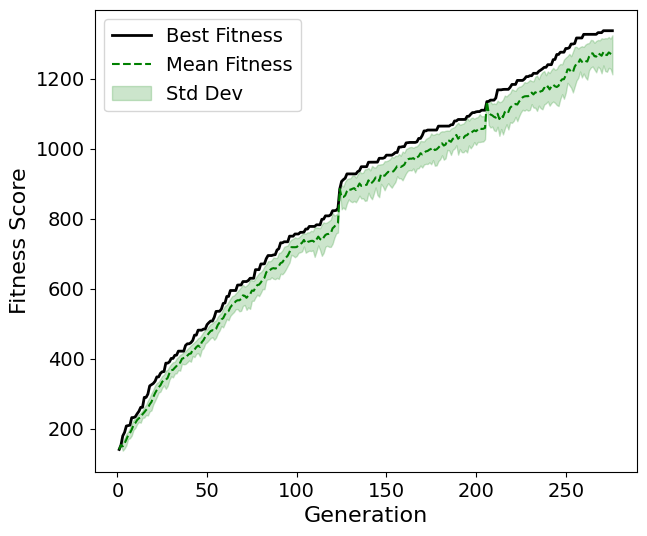

In [18]:

plot_fitness_evolution(best_fitness, mean_fitness, std_fitness, start_gen=1)

In [23]:
from matplotlib.colors import LinearSegmentedColormap

def generate_custom_colormap(zero_color=(0.9, 0.9, 0.9), base_color=(0., 0., 0.)):
    """
    Generate a custom colormap that varies from a given base color to gray.

    Parameters:
    - base_color: Tuple representing the RGB values of the base color.

    Returns:
    - cmap: Custom colormap object.
    """
    # Define the colors for the custom colormap
    colors = [zero_color, base_color]  # Base color and gray

    # Define the color map boundaries
    boundaries = [0, 1]

    # Generate the custom colormap
    cmap = LinearSegmentedColormap.from_list('custom_cmap', colors, N=256)

    return cmap


def plot_simulation(strains_parameters, results_df, T, environmental_conditions):
    """
    Plot the simulation results including environmental input, bacterial density,
    relative abundance, and Shannon diversity over time.
    """
    num_strains = len(strains_parameters)

    # --- Create subplots (now 4 rows)
    fig, axs = plt.subplots(4, figsize=(6, 12), sharex=True)

    # --- Plot 1: Environment Input ---
    lbls = []
    for i in range(num_strains):
        strain_name=strains_parameters[i]['name'][-4:]
        istrain = strain_lbls.index(strain_name[-4:])
        baseline_color = strain_colors[istrain]
        cmap_aa = generate_custom_colormap((1,1,1), baseline_color)
        #concentrations = results_df[f'A_{i+1}'].values

        time = results_df['Time'].values/T
        #for j, concentration in enumerate(environmental_conditions[i]):
        for j in range(len(environmental_conditions)):
            concentration=environmental_conditions[j][i]/Amax

            color = cmap_aa(concentration)
            axs[0].fill_between(time[j:j+2], i, i+1, color=color, alpha=0.7)
        lbls.append(strains_parameters[i]['name'][-4:])
    axs[0].set_yticks(np.arange(num_strains) + 0.5)
    axs[0].set_yticklabels(lbls)

    axs[0].spines['top'].set_visible(False)
    axs[0].spines['right'].set_visible(False)
    axs[0].spines['bottom'].set_visible(False)
    axs[0].spines['left'].set_visible(False)
    axs[0].set_ylim([0, 10])
    axs[0].text(results_df['Time'].iloc[-1]/T / 2, num_strains + 0.5, 'Environment', ha='center', fontsize=14)

    # --- Plot 2: Bacterial Density (log-scale) ---
    for i in range(num_strains):
        strain_name = strains_parameters[i]['name'][-4:]
        istrain = strain_lbls.index(strain_name)
        color = strain_colors[istrain]
        axs[1].plot(results_df['Time'] / T, results_df[f'X_{i+1}'], color=color, linewidth=3)
    axs[1].set_yscale('log')
    axs[1].set_ylim([1e6, 5e9])
    axs[1].set_ylabel("Density (cells/mL)", fontsize=16)

    # --- Plot 3: Relative Abundance ---
    total_density = results_df[[f'X_{i+1}' for i in range(num_strains)]].sum(axis=1)
    for i in range(num_strains):
        strain_name = strains_parameters[i]['name'][-4:]
        istrain = strain_lbls.index(strain_name)
        color = strain_colors[istrain]
        axs[2].plot(results_df['Time'] / T, 100 * results_df[f'X_{i+1}'] / total_density, color=color, linewidth=3, label=strain_name)
    axs[2].set_ylabel("Relative abundance (%)", fontsize=16)

    # --- Plot 4: Diversity Index ---
    relative_proportions = calculate_relative_proportion(results_df)
    diversities = [shannon_diversity(row.values) for _, row in relative_proportions.iterrows()]
    axs[3].plot(results_df['Time'].values / T, diversities, color='k', lw=3)
    axs[3].set_ylabel("Diversity Index", fontsize=16)
    axs[3].set_ylim(0, 1.8)

    # --- Shared x-axis ---
    axs[3].set_xlabel("Time (seasons)", fontsize=16)
    axs[3].set_xlim([0, (results_df['Time']/T).iloc[-1]])

    # --- Styling ---
    for ax in axs:
        ax.tick_params(axis='both', labelsize=14)
    axs[1].legend(lbls, fontsize=12, loc="upper right")
    axs[2].legend(lbls, fontsize=12, loc="upper right")

    plt.tight_layout()
    plt.show()


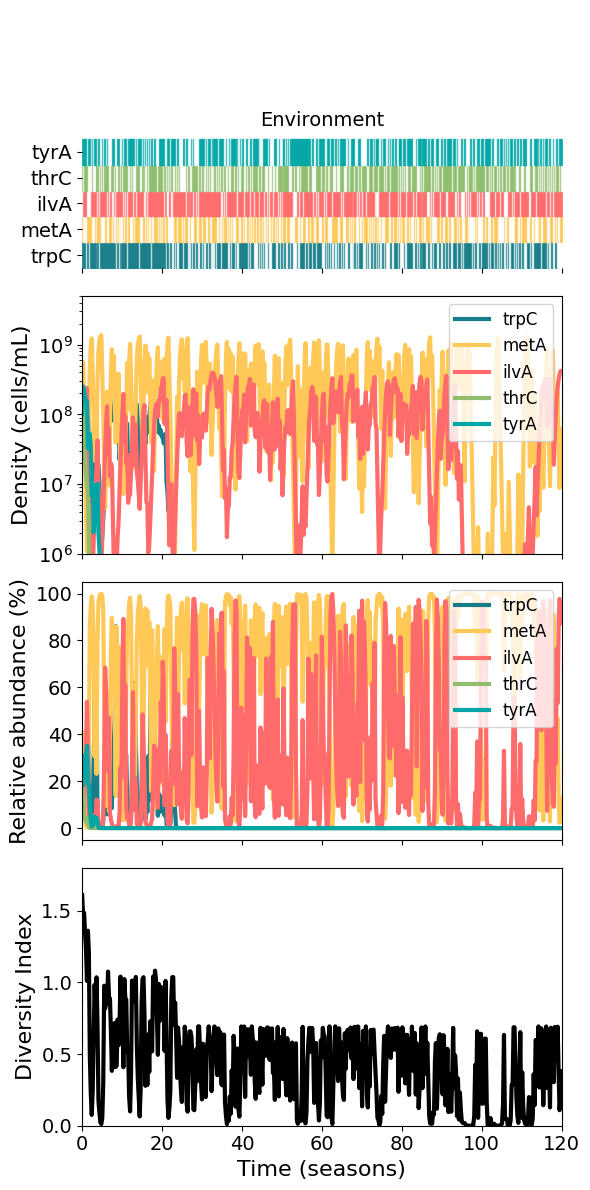

.

In [24]:
best_env=best_environments[np.argmax(best_fitness)]
best_fitness=compute_fitness(strains_parameters, best_env, T, toPlot=True)



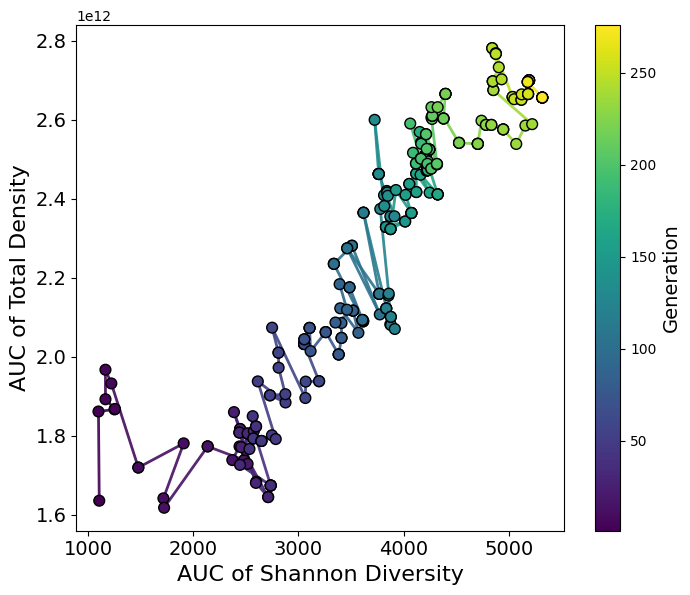

In [25]:
def plot_trajectory_diversity_density(diversity_aucs, density_aucs,
                                      diversity_auc_initial=None, density_auc_initial=None):
    import matplotlib.pyplot as plt
    import numpy as np

    generations = np.arange(1, len(diversity_aucs) + 1)

    plt.figure(figsize=(7, 6))

    # Create a colormap normalized to the number of generations
    norm = plt.Normalize(generations.min(), generations.max())
    cmap = plt.cm.viridis

    # Plot lines connecting each point
    for i in range(1, len(generations)):
        plt.plot(
            [diversity_aucs[i - 1], diversity_aucs[i]],
            [density_aucs[i - 1], density_aucs[i]],
            color=cmap(norm(generations[i])),
            linewidth=2,
            alpha=0.9
        )

    # Scatter plot of points, colored by generation
    scatter = plt.scatter(
        diversity_aucs,
        density_aucs,
        c=generations,
        cmap=cmap,
        edgecolor='k',
        s=60,
        zorder=3
    )

    # Add the initial point in red
    if diversity_auc_initial is not None and density_auc_initial is not None:
        plt.scatter(
            diversity_auc_initial,
            density_auc_initial,
            color='red',
            s=80,
            edgecolor='k',
            zorder=4
        )

    cbar = plt.colorbar(scatter)
    cbar.set_label("Generation", fontsize=14)

    plt.xlabel("AUC of Shannon Diversity", fontsize=16)
    plt.ylabel("AUC of Total Density", fontsize=16)
    plt.grid(False)
    plt.tight_layout()
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.show()



plot_trajectory_diversity_density(
    diversity_aucs, density_aucs,
    diversity_auc_initial=diversity_auc_initial,
    density_auc_initial=density_auc_initial
)


### Replicates

In [35]:

num_reps = 3  # or whatever number of repetitions you have

SAVE_DIRS = [
    f'/content/drive/MyDrive/SYNC_Projects/ProfileX/runs_{rep}/'
    for rep in range(1, num_reps + 1)
]



In [44]:
def load_multiple_fitness_histories(save_dirs, num_generations):
    results = {}

    for save_dir in save_dirs:
        best_fitness = []
        mean_fitness = []
        std_fitness = []
        environments = []
        diversity_aucs = []
        density_aucs = []

        for gen in range(0, num_generations + 1):
            file_path = os.path.join(save_dir, f"best_env_gen{gen}.pkl")
            if os.path.exists(file_path):
                with open(file_path, "rb") as f:
                    data = pickle.load(f)
                    best_fitness.append(data.get("best_fitness", np.nan))
                    mean_fitness.append(data.get("mean_fitness", np.nan))
                    std_fitness.append(data.get("std_fitness", np.nan))
                    environments.append(data.get("environment", None))
                    diversity_aucs.append(data.get("diversity_auc", np.nan))
                    density_aucs.append(data.get("density_auc", np.nan))
            else:
                print(f"Warning: Missing file {file_path}")
                break

        results[save_dir] = {
            "best_fitness": best_fitness,
            "mean_fitness": mean_fitness,
            "std_fitness": std_fitness,
            "environments": environments,
            "diversity_aucs": diversity_aucs,
            "density_aucs": density_aucs
        }

    return results

all_histories = load_multiple_fitness_histories(SAVE_DIRS, num_generations=GENERATIONS)

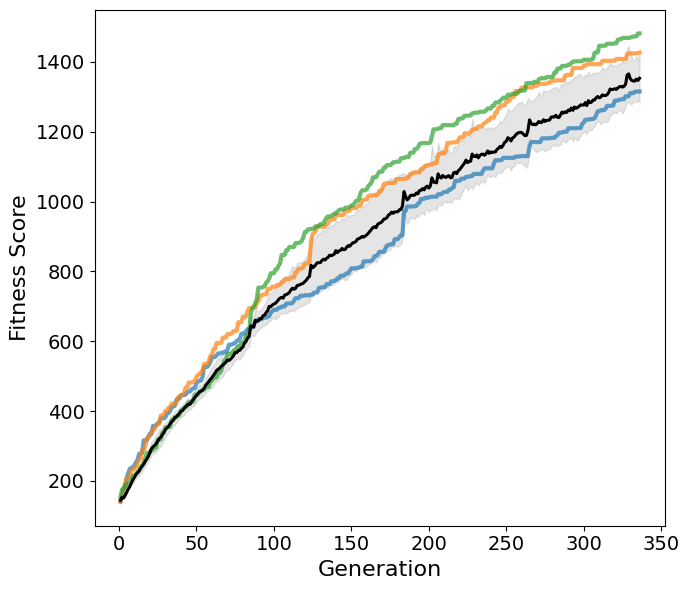

In [52]:
def plot_fitness_evolution_replicates_with_aggregate(histories, start_gen=1):
    """
    histories: dict { save_dir: {"best_fitness": [...], "mean_fitness": [...], "std_fitness": [...], ...} }
    Plots each replicate's best_fitness in color, plus across-replicate mean±std from mean_fitness in grey.
    """

    # Determine the common length
    lengths = [len(rec["mean_fitness"]) for rec in histories.values()]
    L = min(lengths)

    # Stack replicate means and bests
    means_stack = []
    bests_stack = []
    for rec in histories.values():
        mf = np.asarray(rec["mean_fitness"][:L], dtype=float)
        bf = np.asarray(rec["best_fitness"][:L], dtype=float)
        means_stack.append(mf)
        bests_stack.append(bf)

    means_stack = np.vstack(means_stack)  # shape (n_reps, L)
    bests_stack = np.vstack(bests_stack)

    agg_mean = means_stack.mean(axis=0)
    agg_std  = means_stack.std(axis=0)

    gens = np.arange(start_gen, start_gen + L)

    plt.figure(figsize=(7,6))

    # Plot each replicate's best fitness in color
    for i in range(bests_stack.shape[0]):
        plt.plot(gens, bests_stack[i], linewidth=3, alpha=0.7, label=(f"Rep {i+1}" if i < 8 else None))

    # Aggregate mean±std from mean_fitness in grey
    plt.plot(gens, agg_mean, color="black", linewidth=2.2, label="Across-replicate mean (mean fitness)")
    plt.fill_between(gens, agg_mean - agg_std, agg_mean + agg_std,
                     color="grey", alpha=0.2, label="Across-replicate std (mean fitness)")

    plt.xlabel("Generation", fontsize=16)
    plt.ylabel("Fitness Score", fontsize=16)
    #plt.legend(fontsize=11, ncol=2)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.grid(False)
    plt.tight_layout()
    plt.show()


plot_fitness_evolution_replicates_with_aggregate(all_histories)

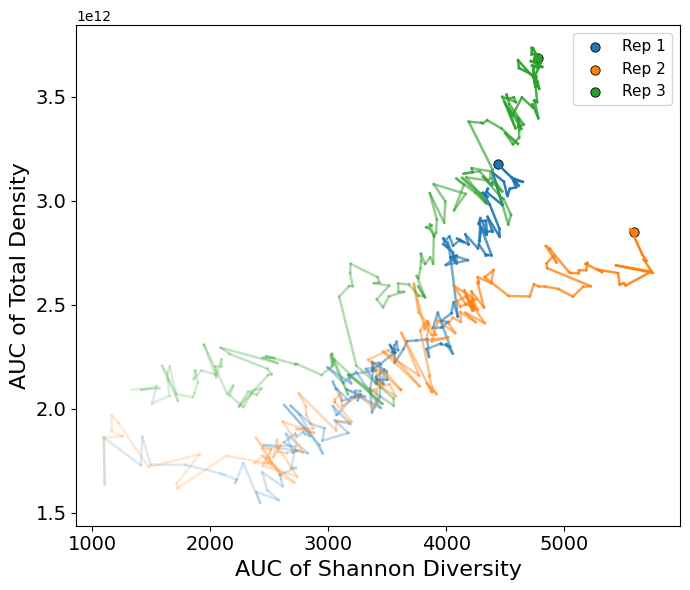

In [59]:
def plot_trajectory_diversity_density_multi(histories,
                                            diversity_auc_initial=None,
                                            density_auc_initial=None,
                                            start_gen=1,
                                            min_alpha=0.15):
    """
    histories: dict { name: {"diversity_aucs": [...], "density_aucs": [...]} }
    Generation is encoded by opacity (early = faint, last = fully opaque).
    Each replicate gets a distinct color.
    """
    import numpy as np
    import matplotlib.pyplot as plt

    # Common length across replicates
    lengths = [len(v["diversity_aucs"]) for v in histories.values()]
    L = min(lengths)
    if L < 2:
        raise ValueError("Not enough points to draw trajectories.")

    # Colors for replicates
    names = list(histories.keys())
    n_reps = len(names)
    cmap_reps = plt.cm.tab10 if n_reps <= 10 else plt.cm.tab20
    rep_colors = [cmap_reps(i % cmap_reps.N) for i in range(n_reps)]

    fig, ax = plt.subplots(figsize=(7, 6))

    # Draw each replicate
    for rep_idx, name in enumerate(names):
        rec = histories[name]
        d = np.asarray(rec["diversity_aucs"][:L], dtype=float)
        y = np.asarray(rec["density_aucs"][:L], dtype=float)
        color = rep_colors[rep_idx]

        # Segments with alpha growing over generations
        for i in range(1, L):
            # alpha ranges from min_alpha to 1.0
            a = min_alpha + (i / (L - 1)) * (1.0 - min_alpha)
            ax.plot([d[i-1], d[i]], [y[i-1], y[i]],
                    color=color, linewidth=1.8, alpha=a)

        # Mark the final point strongly, and add one legend entry per replicate
        ax.scatter(d[-1], y[-1], s=45, color=color, edgecolor='k',
                   linewidth=0.6, label=f"Rep {rep_idx+1}")


    ax.set_xlabel("AUC of Shannon Diversity", fontsize=16)
    ax.set_ylabel("AUC of Total Density", fontsize=16)
    ax.grid(False)
    ax.tick_params(axis='both', labelsize=14)
    ax.legend(fontsize=11, ncol=1)
    plt.tight_layout()
    plt.show()


plot_trajectory_diversity_density_multi(all_histories,
                                        diversity_auc_initial=diversity_auc_initial,
                                        density_auc_initial=density_auc_initial,
                                        start_gen=1)
